## Setup

In [1]:
ACCURACY_STAT_NAME = "mean_accuracy"

In [2]:
from dataclasses import dataclass
from collections import OrderedDict, defaultdict
from pprint import pprint
import pickle
import json
from pathlib import Path

from tqdm import tqdm

import wandb

import pandas as pd

from pvg.constants import WANDB_ENTITY
from pvg.trainers import PureTextEiTrainer

/home/sam/.virtualenvs/pvg-experiments/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 144

In [4]:
# import matplotlib
# font = {'size'   : 22}

# matplotlib.rc('font', **font)

In [5]:
COLOURS = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499", "#DDDDDD"]
SOLO_VERIFIER_COLOUR = COLOURS[0]
PROTOCOL_COLOURS = {
    "ADP": COLOURS[4],
    "Debate": COLOURS[1],
    "NIP": COLOURS[3],
    "MNIP": COLOURS[6],
    "Solo Verifier": SOLO_VERIFIER_COLOUR,
}

In [6]:
COLOUR_RANDOM = SOLO_VERIFIER_COLOUR
COLOUR_STANDARD = COLOURS[2]
COLOURS_RANDOM_STANDARD = [COLOUR_RANDOM, COLOUR_STANDARD]

In [7]:
api = wandb.Api()

In [8]:
@dataclass
class RunSpec:
    project: str
    tag: str

## Graph isomorphism protocols

In [9]:
from collections import OrderedDict

run_group_specs = OrderedDict([
    ("ADP_Standard", RunSpec(project="pvg-sandbox", tag="gi_adp_standard")),
    ("ADP_Random Prover(s)", RunSpec(project="pvg-sandbox", tag="gi_adp_random")),
    ("Debate_Standard", RunSpec(project="pvg-sandbox", tag="gi_debate_standard")),
    ("Debate_Random Prover(s)", RunSpec(project="pvg-sandbox", tag="gi_debate_random")),
    ("NIP_Standard", RunSpec(project="pvg-experiments", tag="gi_rl")),
    ("NIP_Random Prover(s)", RunSpec(project="pvg-experiments", tag="gi_random")),
    ("MNIP_Standard", RunSpec(project="pvg-sandbox", tag="gi_mnip_standard")),
    ("MNIP_Random Prover(s)", RunSpec(project="pvg-sandbox", tag="gi_mnip_random")),
])

In [10]:
mean_accuracies = {}

for run_group_name, run_group_spec in run_group_specs.items():
    runs = api.runs(f"{WANDB_ENTITY}/{run_group_spec.project}", filters={"tags": run_group_spec.tag})
    accuracies = []
    run_found = False
    for run in runs:
        accuracies.append(run.summary[ACCURACY_STAT_NAME])
        run_found = True
    if not run_found:
        raise ValueError(f"No runs found for {run_group_name!r}")
    mean_accuracies[run_group_name] = pd.Series(accuracies)

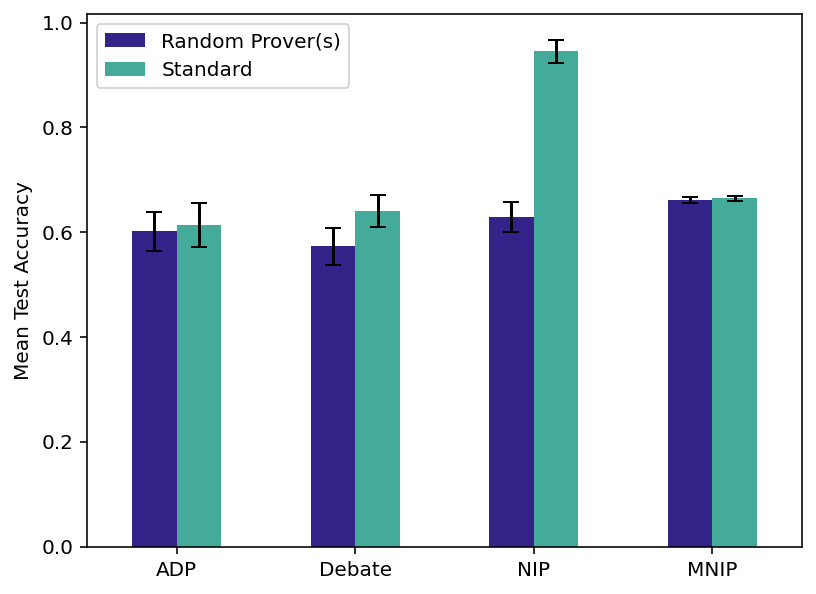

In [11]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for each run group
mean_values = {k: v.mean() for k, v in mean_accuracies.items()}
std_values = {k: v.std() for k, v in mean_accuracies.items()}

# Create a DataFrame for plotting
plot_df = pd.DataFrame({"mean": mean_values, "std": std_values})

# Group the data by prefix
plot_df["prefix"] = plot_df.index.str.split("_").str[0]
plot_df["suffix"] = plot_df.index.str.split("_").str[1]

# Pivot the DataFrame to have 'rl' and 'random' as columns
pivot_df = plot_df.pivot(index="prefix", columns="suffix", values=["mean", "std"])

# Reorder the pivot_df by the order in plot_df
pivot_df = pivot_df.reindex(plot_df["prefix"].unique())

# Reorder columns within each group so that "Standard" is before "Random Prover(s)"
# pivot_df = pivot_df.reindex(columns=["Standard", "Random Prover(s)"], level=1)

# Plot the data
ax = pivot_df["mean"].plot(
    kind="bar", yerr=pivot_df["std"], capsize=4, color=COLOURS_RANDOM_STANDARD
)
# ax.set_title("Mean Test Accuracies for the Graph Isomorphism Task by Protocol", pad=15)
ax.set_ylabel("Mean Test Accuracy")
ax.set_xlabel(None)
ax.legend_.set_title(None)
# ax.legend(loc='upper left')
plt.xticks(rotation=0)
plt.show()

## Graph isomorphism training curve by protocol

In [12]:
run_group_specs = OrderedDict([
    ("ADP", RunSpec(project="pvg-sandbox", tag="gi_adp_standard")),
    ("Debate", RunSpec(project="pvg-sandbox", tag="gi_debate_standard")),
    ("NIP", RunSpec(project="pvg-experiments", tag="gi_rl")),
    ("MNIP", RunSpec(project="pvg-sandbox", tag="gi_mnip_standard")),
])

In [13]:
if "gi_accuracy_histories" not in locals() or "gi_episode_len_histories" not in locals():
    gi_accuracy_histories = defaultdict(list)
    gi_episode_len_histories = defaultdict(list)

    for run_group_name, run_group_spec in run_group_specs.items():
        runs = api.runs(f"{WANDB_ENTITY}/{run_group_spec.project}", filters={"tags": run_group_spec.tag})
        for run in tqdm(runs, desc=run_group_name):
            run_history = run.history()
            gi_accuracy_histories[run_group_name].append(run_history["mean_accuracy"])
            gi_episode_len_histories[run_group_name].append(run_history["mean_episode_length"])
        gi_accuracy_histories[run_group_name] = pd.DataFrame(gi_accuracy_histories[run_group_name])
        gi_episode_len_histories[run_group_name] = pd.DataFrame(gi_episode_len_histories[run_group_name])

MNIP: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


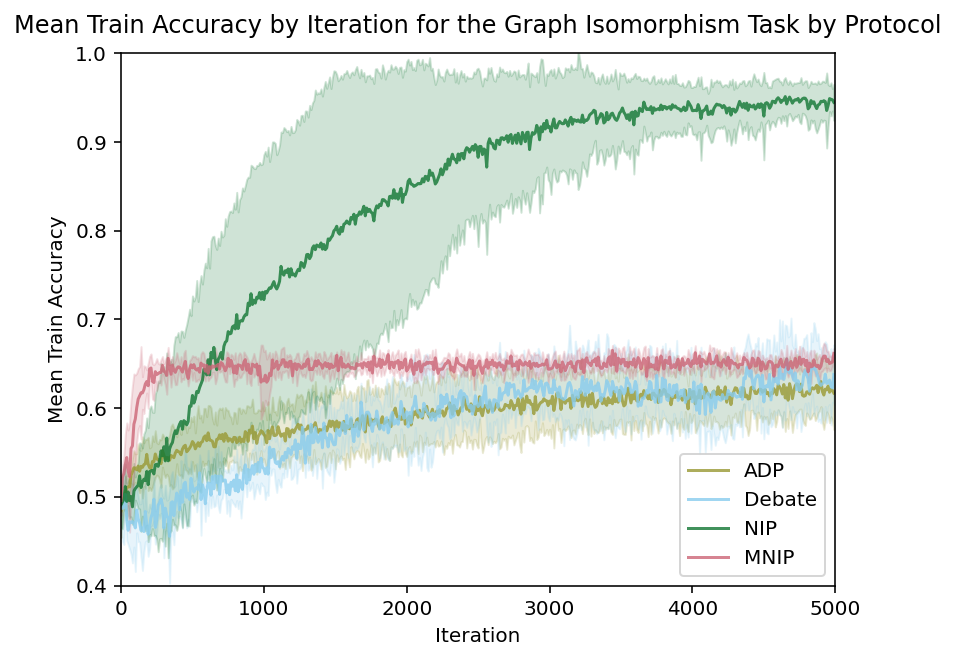

In [14]:
# Calculate mean and standard deviation for each item in accuracy_histories
accuracy_means = {k: v.mean(axis=0) for k, v in gi_accuracy_histories.items()}
accuracy_stds = {k: v.std(axis=0) for k, v in gi_accuracy_histories.items()}

fig, ax = plt.subplots()

for i, (protocol, mean_series) in enumerate(accuracy_means.items()):
    std_series = accuracy_stds[protocol]
    color = PROTOCOL_COLOURS[protocol]
    ax.plot(mean_series.index * 10, mean_series, label=f"{protocol}", color=color, alpha=0.8)
    ax.fill_between(mean_series.index * 10, mean_series - std_series, mean_series + std_series, alpha=0.2, color=color)
    ax.set_xlim(0, 5000)
    ax.set_ylim(0.4, 1)

ax.set_title("Mean Train Accuracy by Iteration for the Graph Isomorphism Task by Protocol", pad=10)
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean Train Accuracy")
ax.legend()
plt.show()

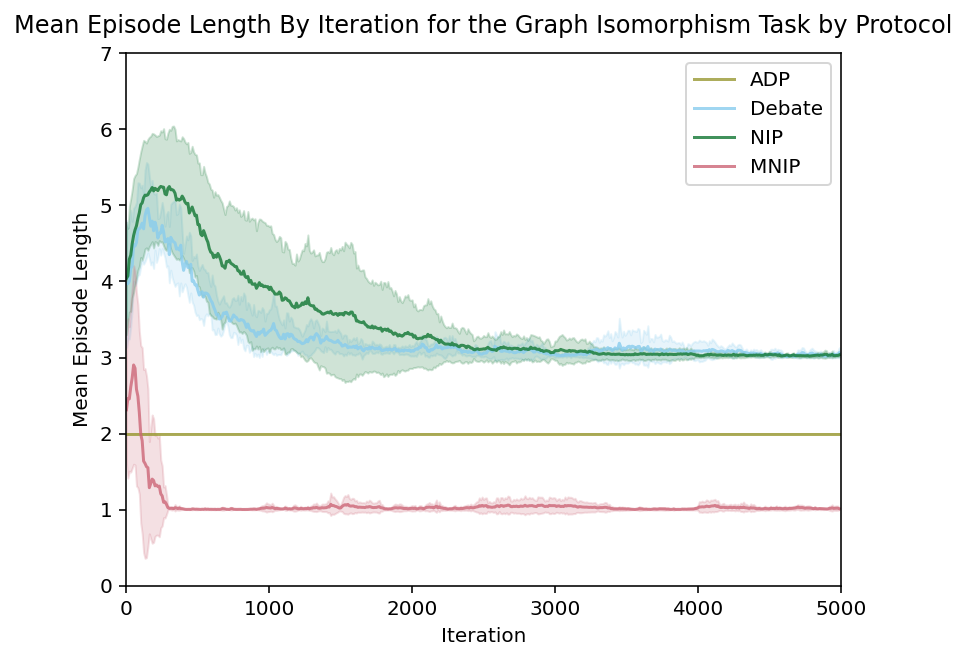

In [15]:
# Calculate mean and standard deviation for each item in episode_len_histories
episode_len_means = {k: v.mean(axis=0) for k, v in gi_episode_len_histories.items()}
episode_len_stds = {k: v.std(axis=0) for k, v in gi_episode_len_histories.items()}

fig, ax = plt.subplots()

for i, (protocol, mean_series) in enumerate(episode_len_means.items()):
    std_series = episode_len_stds[protocol]
    color = PROTOCOL_COLOURS[protocol]
    ax.plot(mean_series.index * 10, mean_series, label=f"{protocol}", color=color, alpha=0.8)
    ax.fill_between(mean_series.index * 10, mean_series - std_series, mean_series + std_series, alpha=0.2, color=color)
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 7.0)

ax.set_title("Mean Episode Length By Iteration for the Graph Isomorphism Task by Protocol", pad=10)
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean Episode Length")
ax.legend()
plt.show()

## Graph isomorphism model size NIP

In [16]:
project = "pvg-experiments"
tag = "gi_iclr_sweep"

In [17]:
runs = api.runs(f"{WANDB_ENTITY}/{project}", filters={"tags": tag})

mean_accuracies = defaultdict(list)

for run in tqdm(runs):
    num_verifier_layers = run.config["agents"]["verifier"]["num_gnn_layers"]
    wide_model = run.config["agents"]["verifier"]["d_gnn"] == 16
    random_prover = "Random Prover" if run.config["agents"]["prover"]["is_random"] else "Standard"
    mean_accuracies[(num_verifier_layers, wide_model, random_prover)].append(
        run.summary[ACCURACY_STAT_NAME]
    )

mean_accuracies = {k: pd.Series(v) for k, v in mean_accuracies.items()}

100%|██████████| 120/120 [00:00<00:00, 300.56it/s]


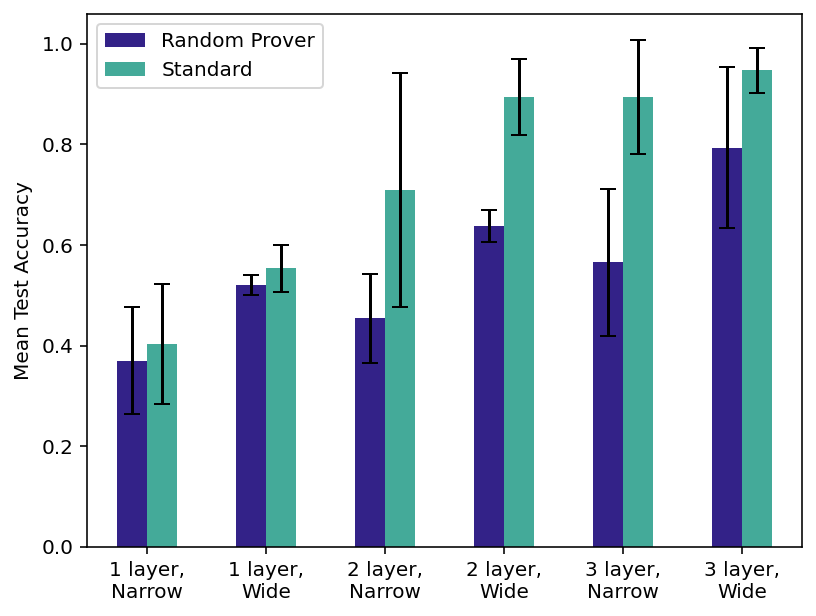

In [18]:
# Calculate mean and standard deviation for each configuration
mean_values = {k: v.mean() for k, v in mean_accuracies.items()}
std_values = {k: v.std() for k, v in mean_accuracies.items()}

# Create a DataFrame for plotting
plot_df = pd.DataFrame({"mean": mean_values, "std": std_values})

# Add a column to indicate whether the configuration is random or non-random
plot_df["random_prover"] = [k[2] for k in plot_df.index]
plot_df["name"] = [f"{k[0]} layer,\n{'Wide' if k[1] else 'Narrow'}" for k in plot_df.index]
# plot_df["name"] = [f"{'wide' if k[1] else 'narrow'}" for k in plot_df.index]

# Pivot the DataFrame to have 'random' and 'non-random' as columns
# pivot_df = plot_df.pivot(index="prefix", columns="suffix", values=["mean", "std"])
pivot_df = plot_df.pivot(index="name", columns="random_prover", values=["mean", "std"])

# pivot_df["ylabel"] = ["Narrow", "Wide"] * 3

# Plot the data
fig, ax = plt.subplots()
pivot_df["mean"].plot(kind="bar", yerr=pivot_df["std"], capsize=4, color=COLOURS_RANDOM_STANDARD, ax=ax, )
# ax.set_title("Mean Test Accuracies for the Graph Isomorphism Task by Model Size (NIP)", pad=10)
ax.set_ylabel("Mean Test Accuracy")
# ax.set_xlabel("Model Configuration", labelpad=10)
ax.set_xlabel(None)
# ax.tick_params(axis='x', which='major', pad=15)
ax.legend_.set_title(None)
# ax.set_xticklabels(["Narrow", "Wide"] * 3)
plt.xticks(rotation=0)
plt.show()

## Graph Isomorphism Model Size Debate/ADP/MNIP

In [19]:
project = "pvg-sandbox"
protocol_name = "Debate"
tag = f"{protocol_name.lower()}_iclr"
prover_name = "prover" if protocol_name == "ADP" else "prover0"

In [20]:
runs = api.runs(f"{WANDB_ENTITY}/{project}", filters={"tags": tag})

mean_accuracies = defaultdict(list)

for run in tqdm(runs):
    num_verifier_layers = run.config["agents"]["verifier"]["num_gnn_layers"]
    wide_model = run.config["agents"]["verifier"]["d_gnn"] == 16
    random_prover = "Random Prover" if run.config["agents"][prover_name]["is_random"] else "Standard"
    mean_accuracies[(num_verifier_layers, random_prover)].append(
        run.summary[ACCURACY_STAT_NAME]
    )

mean_accuracies = {k: pd.Series(v) for k, v in mean_accuracies.items()}

100%|██████████| 75/75 [00:00<00:00, 315.64it/s]


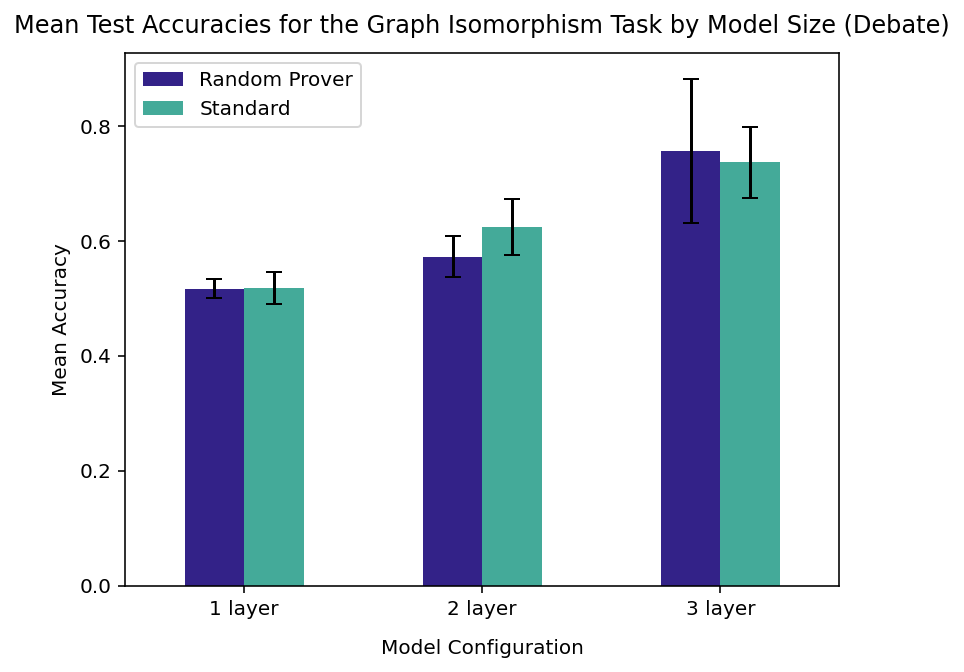

In [21]:
# Calculate mean and standard deviation for each configuration
mean_values = {k: v.mean() for k, v in mean_accuracies.items()}
std_values = {k: v.std() for k, v in mean_accuracies.items()}

# Create a DataFrame for plotting
plot_df = pd.DataFrame({"mean": mean_values, "std": std_values})

# Add a column to indicate whether the configuration is random or non-random
plot_df["random_prover"] = [k[1] for k in plot_df.index]
plot_df["name"] = [f"{k[0]} layer" for k in plot_df.index]
# plot_df["name"] = [f"{'wide' if k[1] else 'narrow'}" for k in plot_df.index]

# Pivot the DataFrame to have 'random' and 'non-random' as columns
# pivot_df = plot_df.pivot(index="prefix", columns="suffix", values=["mean", "std"])
pivot_df = plot_df.pivot(index="name", columns="random_prover", values=["mean", "std"])

# pivot_df["ylabel"] = ["Narrow", "Wide"] * 3

# Plot the data
fig, ax = plt.subplots()
pivot_df["mean"].plot(kind="bar", yerr=pivot_df["std"], capsize=4, color=COLOURS_RANDOM_STANDARD, ax=ax)
ax.set_title(f"Mean Test Accuracies for the Graph Isomorphism Task by Model Size ({protocol_name})", pad=10)
ax.set_ylabel("Mean Accuracy")
ax.set_xlabel("Model Configuration", labelpad=10)
# ax.tick_params(axis='x', which='major', pad=15)
ax.legend_.set_title(None)
# ax.set_xticklabels(["Narrow", "Wide"] * 3)
plt.xticks(rotation=0)
plt.show()

## Graph isomorphism dataset size

In [22]:
project = "pvg-experiments"
tag = "gi_train_size"

In [23]:
runs = api.runs(f"{WANDB_ENTITY}/{project}", filters={"tags": tag})

mean_accuracies = defaultdict(list)

for run in tqdm(runs):
    if "max_train_size" in run.config["dataset_options"]:
        train_size = run.config["dataset_options"]["max_train_size"]
    else:
        train_size = 10000
    random_prover = "Random Prover" if run.config["agents"]["prover"]["is_random"] else "Standard"
    mean_accuracies[train_size].append(
        run.summary["test_mean_accuracy"]
    )

mean_accuracies = {k: pd.Series(v) for k, v in mean_accuracies.items()}

100%|██████████| 87/87 [00:00<00:00, 427.07it/s]


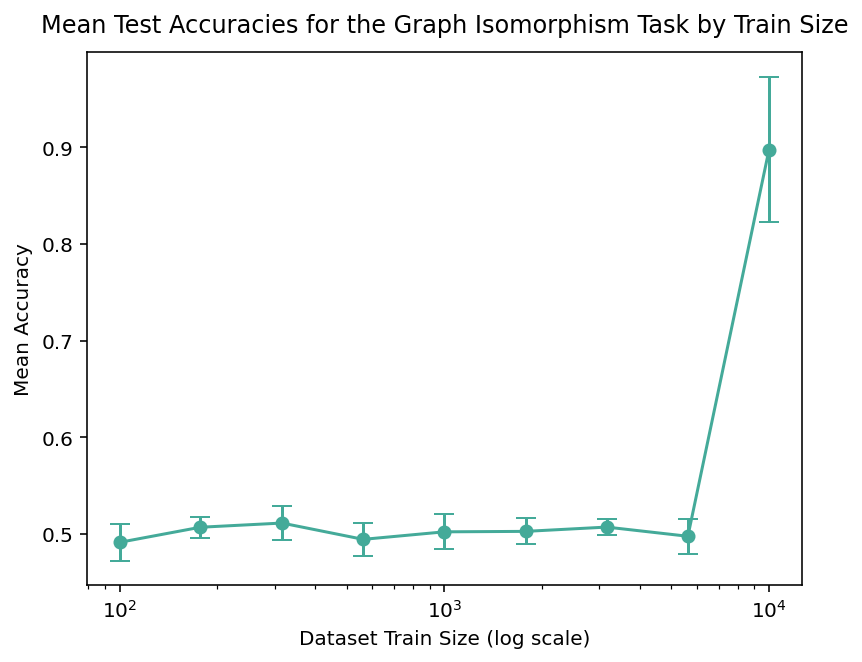

In [24]:
# Calculate mean and standard deviation for each train size
mean_values = {k: v.mean() for k, v in mean_accuracies.items()}
std_values = {k: v.std() for k, v in mean_accuracies.items()}

# Create a DataFrame for plotting
plot_df = pd.DataFrame({"mean": mean_values, "std": std_values})

# Order the DataFrame by train size
plot_df = plot_df.sort_index()

# Plot the data
fig, ax = plt.subplots()
ax.errorbar(plot_df.index, plot_df["mean"], yerr=plot_df["std"], fmt='o', capsize=5, linestyle='-', color=COLOUR_STANDARD)
ax.set_xscale('log')
ax.set_title("Mean Test Accuracies for the Graph Isomorphism Task by Train Size", pad=10)
ax.set_xlabel("Dataset Train Size (log scale)")
ax.set_ylabel("Mean Accuracy")
plt.show()

## Transcripts

In [25]:
checkpoint_names = ["ei_vc_adp_3_0", "ei_vc_200_samples_aggregate_2_0", "ei_vc_debate_200_samples_aggregate_2_0", "ei_vc_mnip_1_0"]
checkpoint_names = ["ei_vc_debate_200_samples_aggregate_2_0"]

In [26]:
for checkpoint_name in checkpoint_names:
    base_dir = PureTextEiTrainer.get_checkpoint_base_dir_from_run_id(
        checkpoint_name
    )
    rollout_dir = base_dir / "rollouts"
    transcript_dir = base_dir / "transcripts"
    transcript_dir.mkdir(exist_ok=True, parents=True)
    for rollout_file in rollout_dir.glob("*.pt"):
        transcript_file = transcript_dir / f"{rollout_file.name[:-3]}.json"
        if transcript_file.exists():
            continue
        with open(rollout_file, "rb") as f:
            rollout = pickle.load(f)
        transcript = rollout["next", "message_history"][:, -1, :, :].tolist()
        with open(transcript_file, "w") as f:
            json.dump(transcript, f, indent=4)

## Code validation training curves

In [27]:
checkpoint_names = OrderedDict([
    ("ADP", "ei_vc_adp_3_0"),
    ("Debate", "ei_vc_debate_200_samples_aggregate_2_0"),
    ("NIP", "ei_vc_200_samples_aggregate_2_0"),
    # ("MNIP", "ei_vc_mnip_1_0"),
])
num_iterations = 8

In [28]:
gi_accuracy_histories = {}
gi_episode_len_histories = {}

for protocol_name, checkpoint_name in checkpoint_names.items():
    run = api.run(f"{WANDB_ENTITY}/pvg-code-validation-sandbox/{checkpoint_name}")
    run_history = run.history(keys=["mean_accuracy", "mean_episode_length"])
    gi_accuracy_histories[protocol_name] = run_history["mean_accuracy"][:num_iterations]
    gi_episode_len_histories[protocol_name] = run_history["mean_episode_length"][:num_iterations]

In [29]:
run = api.run(f"{WANDB_ENTITY}/pvg-code-validation-sandbox/ei_vc_solo_verifier_0")
run_history = run.history(keys=["mean_accuracy"])
gi_accuracy_histories["Solo Verifier"] = run_history["mean_accuracy"][:num_iterations]

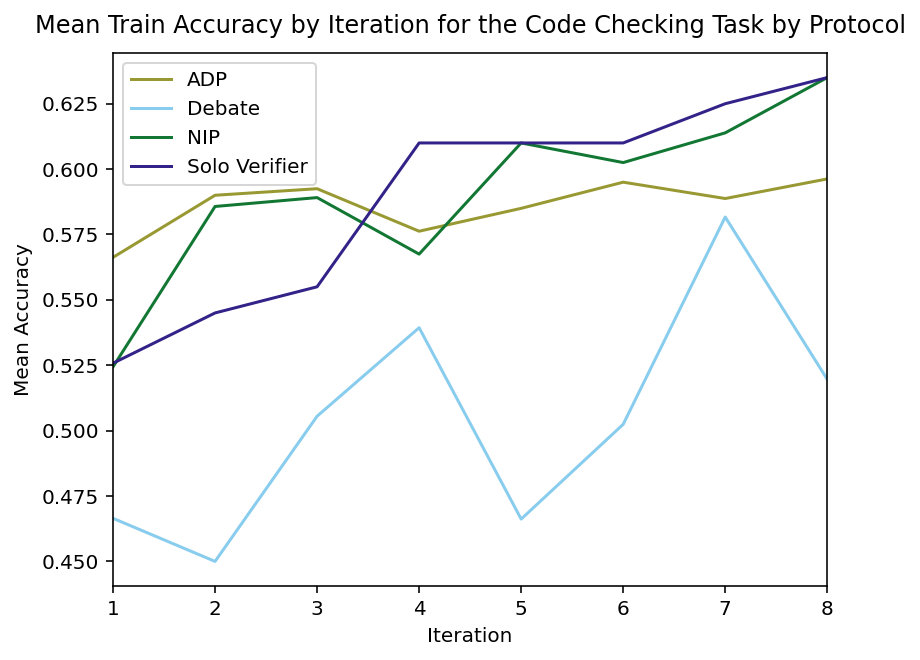

In [30]:
fig, ax = plt.subplots()

for i, (protocol, history) in enumerate(gi_accuracy_histories.items()):
    color = PROTOCOL_COLOURS[protocol]
    ax.plot(history.index + 1, history, label=protocol, color=color)  # Adjust index to start at 1

ax.set_title("Mean Train Accuracy by Iteration for the Code Checking Task by Protocol", pad=10)
ax.set_xlabel("Iteration")
ax.set_xlim(1, num_iterations)
ax.set_ylabel("Mean Accuracy")
ax.legend()
plt.show()

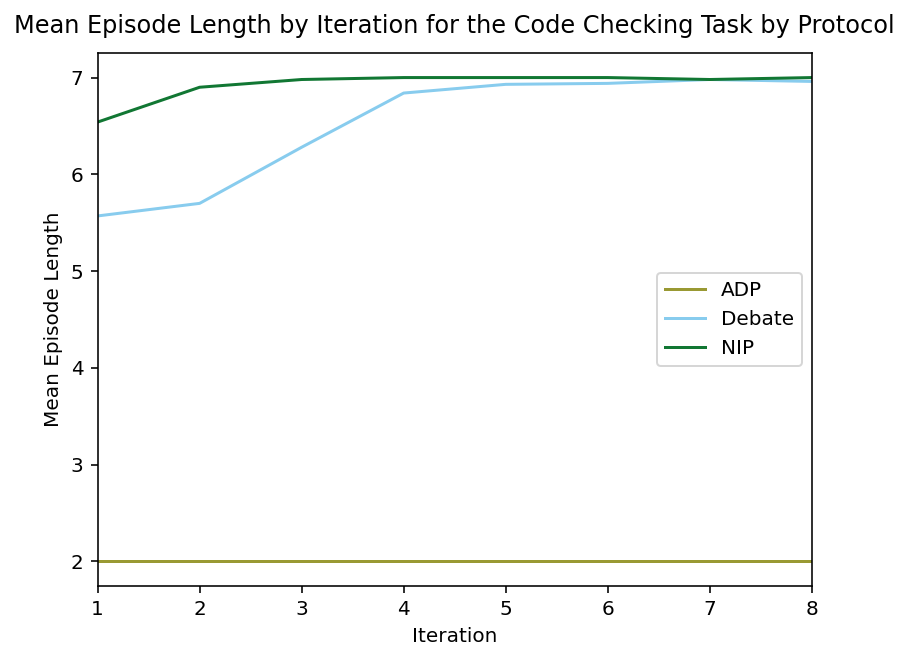

In [58]:
fig, ax = plt.subplots()

for i, (protocol, history) in enumerate(gi_episode_len_histories.items()):
    color = PROTOCOL_COLOURS[protocol]
    ax.plot(history.index + 1, history, label=protocol, color=color)  # Adjust index to start at 1

ax.set_title("Mean Episode Length by Iteration for the Code Checking Task by Protocol", pad=10)
ax.set_xlabel("Iteration")
ax.set_xlim(1, num_iterations)
ax.set_ylabel("Mean Episode Length")
ax.legend()
plt.show()

## Transcript analysis

In [47]:
checkpoint_names = OrderedDict([
    ("ADP", "ei_vc_adp_3_0"),
    ("Debate", "ei_vc_debate_200_samples_aggregate_2_0"),
    ("NIP", "ei_vc_200_samples_aggregate_2_0"),
    # ("MNIP", "ei_vc_mnip_1_0"),
])
num_iterations = 8
analyser = "prover_role_conformance"
analyser = "prover_direct_quotation"
# analyser = "prover_accurate_quotation"
# analyser = "follow_up"
analyser_name = analyser.replace("_", " ").title()

In [48]:
mean_evaluations = defaultdict(list)

for protocol_name, checkpoint_name in checkpoint_names.items():
    base_dir = PureTextEiTrainer.get_checkpoint_base_dir_from_run_id(
        checkpoint_name
    )
    analysis_dir = base_dir / "analysis"
    for iteration in range(num_iterations):
        analysis_file = analysis_dir / analyser / f"{iteration}.pt"
        with open(analysis_file, "rb") as f:
            analysis = pickle.load(f)
        for (agent_name, channel_name), evaluation in analysis.items():
            if agent_name == "prover0" and channel_name == "prover1_channel":
                continue
            if agent_name == "prover1" and channel_name == "prover0_channel":
                continue
            if agent_name == "verifier" and channel_name == "prover0_channel":
                continue
            mean = evaluation.mean().item()
            if analyser == "prover_role_conformance" and agent_name == "prover1" and protocol_name == "Debate":
                mean = 1 - mean
            mean_evaluations[f"{protocol_name} ({agent_name})"].append(mean)

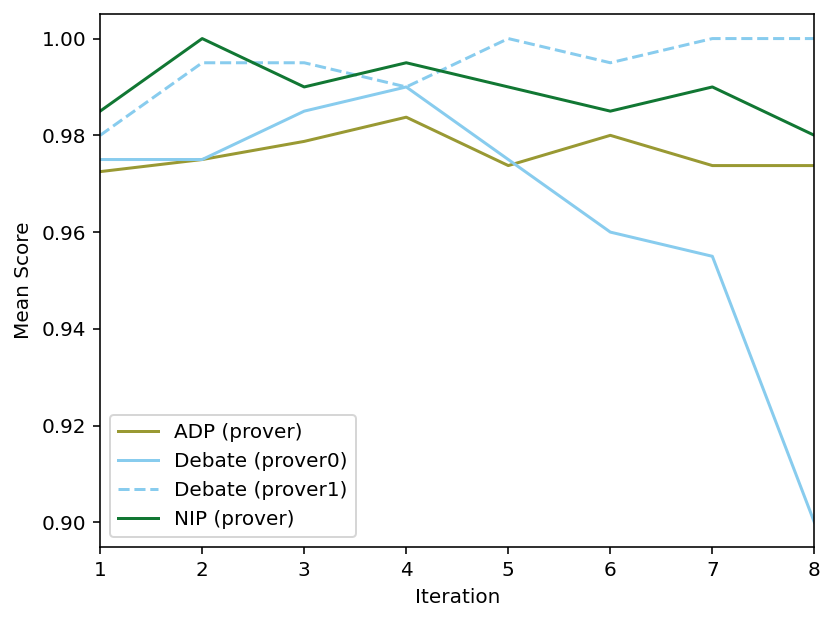

In [49]:
fig, ax = plt.subplots()

linestyles = ["solid", "dashed", "dotted", "dashdot"]

protocol_count = defaultdict(int)

for i, (protocol_agent, evaluations) in enumerate(mean_evaluations.items()):
    protocol, agent = protocol_agent.split(" (")
    color = PROTOCOL_COLOURS[protocol]
    ax.plot(
        range(1, len(evaluations) + 1),
        evaluations,
        linestyle=linestyles[protocol_count[protocol]],
        label=protocol_agent,
        color=color,
    )
    protocol_count[protocol] += 1

# ax.set_title(f"Mean Scores for {analyser_name!r} by Protocol", pad=10)
ax.set_xlabel("Iteration")
ax.set_xlim(1, num_iterations)
ax.set_ylabel("Mean Score")
# ax.set_ylim(bottom=0, top=1.01)
ax.legend()
plt.show()

## CV Test accuracies

In [50]:
test_accuracies = {
    "ADP": 0.57625,
    "Debate": 0.5225,
    "NIP": 0.5575,
}

solo_accuracy = 0.555

In [51]:
test_accuracies = {
    "ADP": 0.59,
    "Debate": 0.5225,
    "NIP": 0.6,
}

solo_accuracy = 0.565

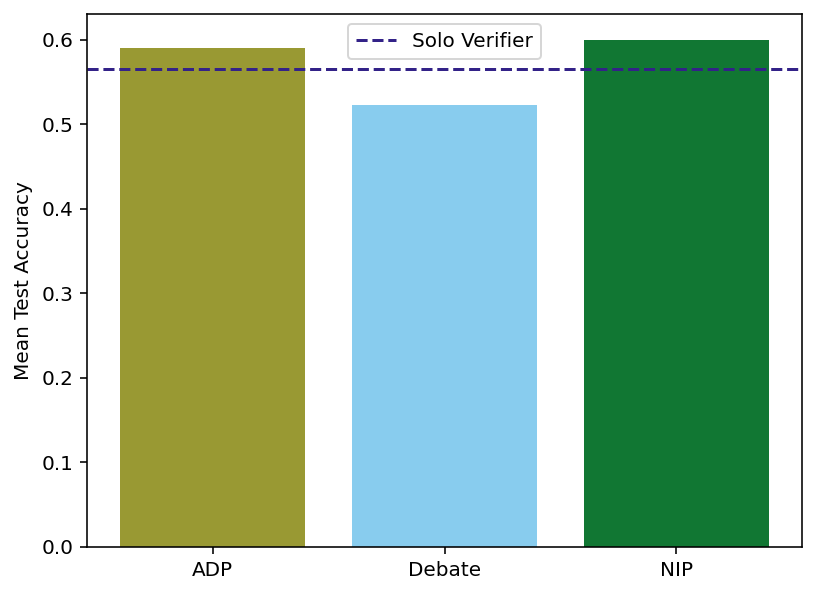

In [52]:
# Plot the test accuracies as a bar chart
fig, ax = plt.subplots()

# Extract protocols and their corresponding accuracies
protocols = list(test_accuracies.keys())
accuracies = list(test_accuracies.values())

# Get colors for each protocol
colors = [PROTOCOL_COLOURS.get(protocol, "#000000") for protocol in protocols]

# Create the bar chart
ax.bar(protocols, accuracies, color=colors)

# Add a vertical line for solo_accuracy
ax.axhline(solo_accuracy, color=SOLO_VERIFIER_COLOUR, linestyle='--', label="Solo Verifier")

# Set the title and labels
# ax.set_title("Mean Test Accuracies for the Code Validation Task by Protocol", pad=10)
ax.set_ylabel("Mean Test Accuracy")
# ax.set_xlabel("Protocol", labelpad=10)

# Add legend
ax.legend()

# Display the plot
plt.show()

['ADP', 'Debate', 'NIP'] [0.59, 0.5225, 0.6]


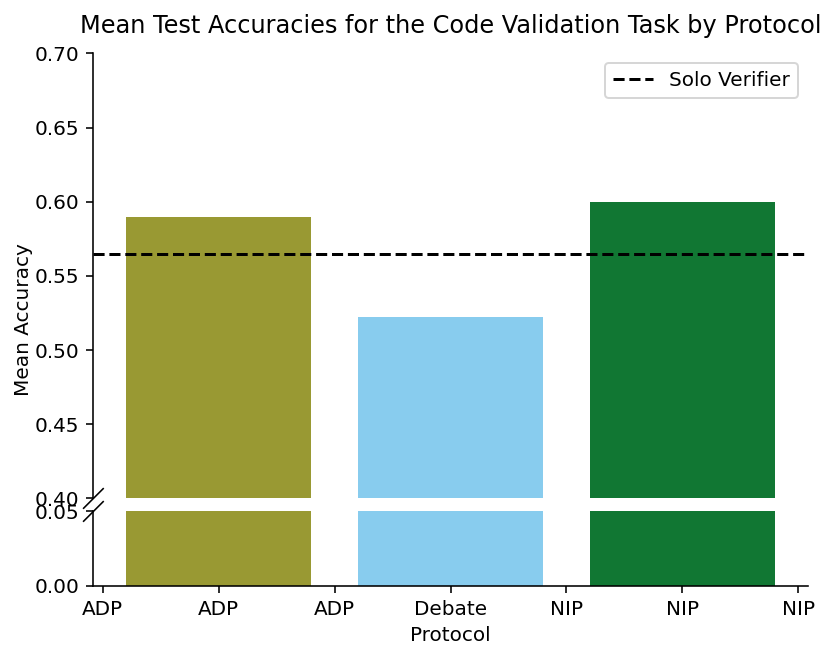

In [53]:
import brokenaxes

# Plot the test accuracies as a bar chart
fig = plt.figure()
bax = brokenaxes.brokenaxes(ylims=((0, 0.05), (0.4, 0.7)), hspace=0.05)

# Extract protocols and their corresponding accuracies
protocols = list(test_accuracies.keys())
accuracies = list(test_accuracies.values())

# Get colors for each protocol
colors = [PROTOCOL_COLOURS.get(protocol, "#000000") for protocol in protocols]

print(protocols, accuracies)

# Create the bar chart
bax.bar(protocols, accuracies, color=colors)

# Add a vertical line for solo_accuracy
bax.axhline(solo_accuracy, color="k", linestyle='--', label="Solo Verifier")

# Set the title and labels
bax.set_title("Mean Test Accuracies for the Code Validation Task by Protocol", pad=10)
bax.set_ylabel("Mean Accuracy")
bax.set_xlabel("Protocol", labelpad=20)

# Add legend
bax.legend()

# Display the plot
plt.show()